In [1]:
#! pip3 install virtualenv
!pip3 install --user ipykernel


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
! python -m ipykernel install --user --name=mychurn

/System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: No module named ipykernel


In [3]:
#! pip install seaborn
! pip install tensorflow


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [4]:
! pip install imblearn


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout , BatchNormalization
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import json

SEED = 42
np.random.seed(SEED)

2022-12-31 21:59:21.462396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
df = pd.read_csv("./data/bank_data_train.csv")
test = pd.read_csv("./data/bank_data_test.csv")
print(f'Размерность данных:\n\ttrain: {df.shape} \n\ttest: {test.shape}')
df.head()

Размерность данных:
	train: (355190, 116) 
	test: (88798, 116)


,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,PRC_ACCEPTS_A_EMAIL_LINK,APP_REGISTR_RGN_CODE,PRC_ACCEPTS_A_POS,PRC_ACCEPTS_A_TK,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,...,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,146841,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
1,146842,0,0.041033,NaN,NaN,NaN,NaN,0.0,0.166667,0.186107,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
2,146843,0,0.006915,0.0,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
3,146844,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
4,146845,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0


In [7]:
df['TARGET'].value_counts()

0    326265
1     28925
Name: TARGET, dtype: int64

In [8]:
df.columns

Index(['ID', 'CR_PROD_CNT_IL', 'AMOUNT_RUB_CLO_PRC',
       'PRC_ACCEPTS_A_EMAIL_LINK', 'APP_REGISTR_RGN_CODE', 'PRC_ACCEPTS_A_POS',
       'PRC_ACCEPTS_A_TK', 'TURNOVER_DYNAMIC_IL_1M', 'CNT_TRAN_AUT_TENDENCY1M',
       'SUM_TRAN_AUT_TENDENCY1M',
       ...
       'REST_DYNAMIC_CC_3M', 'MED_DEBT_PRC_YWZ', 'LDEAL_ACT_DAYS_PCT_TR3',
       'LDEAL_ACT_DAYS_PCT_AAVG', 'LDEAL_DELINQ_PER_MAXYWZ',
       'TURNOVER_DYNAMIC_CC_3M', 'LDEAL_ACT_DAYS_PCT_TR',
       'LDEAL_ACT_DAYS_PCT_TR4', 'LDEAL_ACT_DAYS_PCT_CURR', 'TARGET'],
      dtype='object', length=116)

## Обработка

### Работа с пропусками 

#### План
Посмотрим на наши данные с пропусками и определим какие серии мы будем рассматривать, а какие просто дропнем
1. Посчитаем количество пропусков в каждой серии 
2. Посмотрим на распределение (увидим два горба и просто осечем все что больше точки перегиба)

#### 1. Считаем пропуски

In [9]:
count_nulls = df.isnull().sum()
count_nulls

ID                               0
CR_PROD_CNT_IL                   0
AMOUNT_RUB_CLO_PRC           38323
PRC_ACCEPTS_A_EMAIL_LINK    200027
APP_REGISTR_RGN_CODE        294640
                             ...  
TURNOVER_DYNAMIC_CC_3M           0
LDEAL_ACT_DAYS_PCT_TR       261742
LDEAL_ACT_DAYS_PCT_TR4      261742
LDEAL_ACT_DAYS_PCT_CURR     261742
TARGET                           0
Length: 116, dtype: int64

Точку перегиба искал руками просто подбором используя плотность распределния `stats.gaussian_kde(null_counts).pdf(100500)`

In [10]:
threshold = 155400 #155400 # тут +/- точка перегиба

#### 2. Строим график

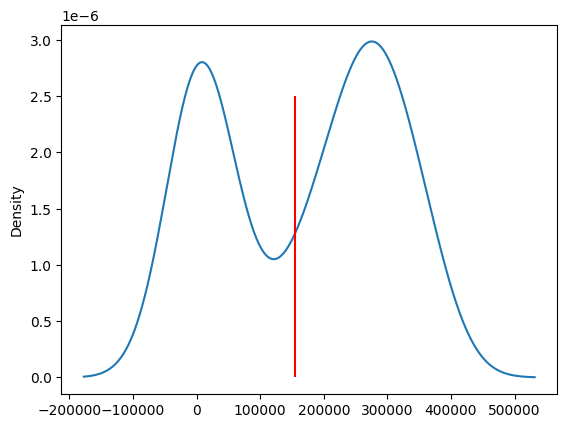

In [11]:
count_nulls.plot.kde()
plt.vlines(threshold, 0, 2.5e-06, color = 'r')
plt.show()

#### 3. Дропаем все что больше порога

In [12]:
not_null_columns = count_nulls[count_nulls < threshold].index

In [13]:
df_drop = df[not_null_columns]
df_drop.shape

(355190, 49)

### Работа с типами данных

#### План
1. Посмотреть на типы данных
2. Если есть типы данных отличные от численных, попробовать закодировать

In [14]:
df_drop_factorize = df_drop.copy()

In [15]:
x = df_drop_factorize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355190 entries, 0 to 355189
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        355190 non-null  int64  
 1   CR_PROD_CNT_IL            355190 non-null  int64  
 2   AMOUNT_RUB_CLO_PRC        316867 non-null  float64
 3   TURNOVER_DYNAMIC_IL_1M    355190 non-null  float64
 4   AMOUNT_RUB_SUP_PRC        316867 non-null  float64
 5   REST_DYNAMIC_FDEP_1M      355190 non-null  float64
 6   REST_DYNAMIC_SAVE_3M      355190 non-null  float64
 7   CR_PROD_CNT_VCU           355190 non-null  int64  
 8   REST_AVG_CUR              355190 non-null  float64
 9   AMOUNT_RUB_NAS_PRC        316867 non-null  float64
 10  CLNT_JOB_POSITION         210811 non-null  object 
 11  TRANS_COUNT_SUP_PRC       316867 non-null  float64
 12  TRANS_COUNT_NAS_PRC       316867 non-null  float64
 13  CR_PROD_CNT_TOVR          355190 non-null  i

У нас есть только два типа один `object` преобразуем их

In [16]:
meta = {}
cat_feat = df_drop_factorize.select_dtypes(include=['object']).columns.tolist()
for col in cat_feat:
    meta[col] = LabelEncoder()
    df_drop_factorize[col] = meta[col].fit_transform(df_drop_factorize[col].fillna('0'))

### Работа с выбросами и заполнение пустот

#### План
1. Строим гистограммы
2. Дропаем строки с выбросами
3. Все пустоты в признаках заполняем медианными значениями (тут можно поиграт)

In [17]:
df_drop_factorize.fillna(df_drop_factorize.mean(), inplace=True)

In [18]:
def myScale(df):
    for col in df.drop('TARGET', axis=1).columns:
        mean_, std_ = df[col].mean(), df[col].std()
        df[col] = (df[col] - mean_) / std_
    return df.drop(['ID', 'TARGET'], axis=1), df.TARGET, df.columns

In [19]:
df_scale, y, columns = myScale(df_drop_factorize)

### Разделяем выборку на тестовую и тренировочную ( 20% )

In [20]:
%%time
data = {}
data['X_train'], data['X_test'], data['y_train'], data['y_test'] = train_test_split(df_scale, y, test_size=0.2)

CPU times: user 181 ms, sys: 46.9 ms, total: 228 ms
Wall time: 284 ms


## Обучение моделей

### Вспомогательные функции для сбора данных

In [21]:
def myScore(data, prediction, name, config):
    result = {
        'name': name,
        'train AUC': roc_auc_score(data['y_train'], prediction[0]),
        'test AUC': roc_auc_score(data['y_test'], prediction[1]),
        'train ACC': accuracy_score(data['y_train'], (prediction[0] > 0.5).astype(int)),
        'test ACC': accuracy_score(data['y_test'], (prediction[1] > 0.5).astype(int)),
        'config': config
    }
    
    for name, val in result.items():
        print(f'{name}: {val}')
        
    return result

In [22]:
def myPredict(res_table, data, model_class, config):
    
    model = model_class(config)
    if config.get('model'):
        del config['model']
    model_name = model_class.__name__ + ': ' + json.dumps(config)
    
    model.fit(data['X_train'], data['y_train']),
    models[model_name] = model
    prediction = (
        model.predict(data['X_train']),
        model.predict(data['X_test'])
    )
    
    res_table = res_table.append(myScore(data, prediction, model_name, config), ignore_index=True)
    
    return res_table, models 

In [23]:
models = {}
res_table = pd.DataFrame(columns=['name', 'train AUC', 'test AUC', 'train ACC', 'test ACC', 'config'])
res_table

,name,train AUC,test AUC,train ACC,test ACC,config


### Обертки для моделей

#### BernoulliNB

In [24]:
class WrapperNaive:
    def __init__(self, hp):
        self.binarize = hp.get('binarize', 5)
        
    def fit(self, X, y):
        X = X.values.astype('float32')

        self.model = BernoulliNB(binarize = self.binarize)
        self.model.fit(X, y)
        
    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

#### Keras

In [25]:
class WrapperKeras:
    def __init__(self, hp):
        self.epochs = hp.get('epochs', 50)
        self.batch_size = hp.get('batch_size', 512)
        self.model = hp['model']
        
    def fit(self, X, y):
        X = X.values.astype('float32')
        y = pd.get_dummies(y).values.astype('float32')

        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size)
        
    def predict(self, X):
        return self.model.predict(X.values.astype('float32'))[:, 1]

#### GridSearch RandomForestClassifier

In [26]:
class WrapperRFGridSearch:
    def __init__(self, param_grid, metric = 'roc_auc'):
        self.param_grid = param_grid
        self.metric = metric
    
    def fit(self, X, y):
        gs = GridSearchCV(
            estimator=RandomForestClassifier(), 
            param_grid=self.param_grid, 
            scoring=self.metric,
            cv=5,
            verbose=1,
            n_jobs=-1
        )
        
        gs.fit(X, y)
        self.model = gs.best_estimator_

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

#### GridSearch MLPClassifier

In [27]:
class WrapperMLPGrid:
    def __init__(self, param_grid, metric = 'roc_auc'):
        self.param_grid = param_grid
        self.metric = metric
    
    def fit(self, X, y):
        gs = GridSearchCV(
            estimator=MLPClassifier(), 
            param_grid=self.param_grid, 
            cv=5,
            verbose=1,
            n_jobs=-1,
            scoring=self.metric
        )
        gs.fit(X, y)
        
        self.model = gs.best_estimator_

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

### Конструируем модель для keras 

In [28]:
def createKerasModel(inputN):
    model = Sequential()
    model.add(Dense(40, input_shape=(inputN, ), activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(45, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(65, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(45, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(45, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

### Запускаем модели

#### Baseline naive classifier

In [29]:
res_table, models = myPredict(res_table, data, WrapperNaive, {'binarize': 2})

name: WrapperNaive: {"binarize": 2}
train AUC: 0.6051795498822086
test AUC: 0.6078784411804842
train ACC: 0.8962562290605028
test ACC: 0.8971114051634337
config: {'binarize': 2}


In [30]:
res_table, models = myPredict(res_table, data, WrapperNaive, {'binarize': 5})

name: WrapperNaive: {"binarize": 5}
train AUC: 0.5331269803979012
test AUC: 0.5308977375121493
train ACC: 0.9180614600636279
test ACC: 0.9191418677327627
config: {'binarize': 5}


In [31]:
res_table

,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
1,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}


#### Запускаем Keras

* на 50 эпох

In [32]:
kerasModel = createKerasModel(data['X_train'].shape[1])
config = {'epochs': 50, 'model': kerasModel}

2022-12-31 21:59:33.458687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
res_table, models = myPredict(res_table, data, WrapperKeras, config)

Epoch 1/50
555/555 [==============================] - 4s 3ms/step - loss: 0.3388
Epoch 2/50
555/555 [==============================] - 2s 4ms/step - loss: 0.2598
Epoch 3/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2549
Epoch 4/50
555/555 [==============================] - 2s 4ms/step - loss: 0.2514
Epoch 5/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2480
Epoch 6/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2450
Epoch 7/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2424
Epoch 8/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2405
Epoch 9/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2379
Epoch 10/50
555/555 [==============================] - 2s 4ms/step - loss: 0.2374
Epoch 11/50
555/555 [==============================] - 2s 4ms/step - loss: 0.2360
Epoch 12/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2348
Epoch 13/50
555/555 [====

* на 200 эпох

In [34]:
kerasModel = createKerasModel(data['X_train'].shape[1])
config = {'epochs': 200, 'model': kerasModel}
res_table, models = myPredict(res_table, data, WrapperKeras, config)

Epoch 1/200
555/555 [==============================] - 4s 3ms/step - loss: 0.3396
Epoch 2/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2588
Epoch 3/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2540
Epoch 4/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2500
Epoch 5/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2472
Epoch 6/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2448
Epoch 7/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2418
Epoch 8/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2399
Epoch 9/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2376
Epoch 10/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2372
Epoch 11/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2359
Epoch 12/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2347
Epoch 13/200


555/555 [==============================] - 2s 3ms/step - loss: 0.2218
Epoch 100/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2219
Epoch 101/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2220
Epoch 102/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2218
Epoch 103/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2219
Epoch 104/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2218
Epoch 105/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2216
Epoch 106/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2220
Epoch 107/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2219
Epoch 108/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2219
Epoch 109/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2219
Epoch 110/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2215
Epoch 

555/555 [==============================] - 2s 3ms/step - loss: 0.2192
Epoch 197/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2192
Epoch 198/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2193
Epoch 199/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2192
Epoch 200/200
2220/2220 [==============================] - 2s 717us/step
name: WrapperKeras: {"epochs": 200}
train AUC: 0.8623719170079898
test AUC: 0.8401004461084505
train ACC: 0.9200779864297981
test ACC: 0.919803485458487
config: {'epochs': 200}


In [35]:
res_table

,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
1,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
2,"WrapperKeras: {""epochs"": 50}",0.844819,0.833026,0.919223,0.919986,{'epochs': 50}
3,"WrapperKeras: {""epochs"": 200}",0.862372,0.840100,0.920078,0.919803,{'epochs': 200}


#### Запускаем Multi-layer Perceptron classifier

In [36]:
%%time
param_grid = {
    'solver': ['adam'],
    'max_iter': [50, 100], #  
    'activation': ['relu', 'logistic'], # 
    'hidden_layer_sizes': [(62, 32, 1)]
}

res_table, models = myPredict(res_table, data, WrapperMLPGrid, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py

name: WrapperMLPGrid: {"solver": ["adam"], "max_iter": [50, 100], "activation": ["relu", "logistic"], "hidden_layer_sizes": [[62, 32, 1]]}
train AUC: 0.848121174980258
test AUC: 0.8228794805156252
train ACC: 0.9192791182184183
test ACC: 0.9190010980038853
config: {'solver': ['adam'], 'max_iter': [50, 100], 'activation': ['relu', 'logistic'], 'hidden_layer_sizes': [(62, 32, 1)]}
CPU times: user 13min 44s, sys: 1min 43s, total: 15min 28s
Wall time: 8min 53s


In [37]:
res_table

,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
1,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
2,"WrapperKeras: {""epochs"": 50}",0.844819,0.833026,0.919223,0.919986,{'epochs': 50}
3,"WrapperKeras: {""epochs"": 200}",0.862372,0.840100,0.920078,0.919803,{'epochs': 200}
4,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."


#### Запускаем RandomForestClassifier

In [38]:
%%time

param_grid = {
    'n_estimators': [200], # количество деревьев в лесу
    'max_features': ['sqrt'], #  размер случайных подмножеств функций, которые следует учитывать при разделении узла
    'max_depth': [32], # максимальная глубина дерева
    'criterion': ['entropy'], # функция измерения качества разделения
}

res_table, models = myPredict(res_table, data, WrapperRFGridSearch, param_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
name: WrapperRFGridSearch: {"n_estimators": [200], "max_features": ["sqrt"], "max_depth": [32], "criterion": ["entropy"]}
train AUC: 0.9999939244342466
test AUC: 0.8419617285310099
train ACC: 0.9975822799065289
test ACC: 0.9203947183197725
config: {'n_estimators': [200], 'max_features': ['sqrt'], 'max_depth': [32], 'criterion': ['entropy']}
CPU times: user 3min 17s, sys: 503 ms, total: 3min 17s
Wall time: 7min 3s


In [39]:
res_table

,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
1,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
2,"WrapperKeras: {""epochs"": 50}",0.844819,0.833026,0.919223,0.919986,{'epochs': 50}
3,"WrapperKeras: {""epochs"": 200}",0.862372,0.840100,0.920078,0.919803,{'epochs': 200}
4,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."
5,"WrapperRFGridSearch: {""n_estimators"": [200], ""...",0.999994,0.841962,0.997582,0.920395,"{'n_estimators': [200], 'max_features': ['sqrt..."


### Делаем микс моделей чтобы достичь `0.85`

In [40]:
def compositionModel(composition_models, weights):
    pred = 0
    for i in range(len(composition_models)):
        model = composition_models[i]
        weight = weights[i]
        print(model, pred)
        pred += model.predict(data['X_test']) * weight
    print(roc_auc_score(data['y_test'], pred / len(composition_models)))

In [41]:
models

{'WrapperNaive: {"binarize": 2}': <__main__.WrapperNaive at 0x168ddba00>,
 'WrapperNaive: {"binarize": 5}': <__main__.WrapperNaive at 0x168dd9270>,
 'WrapperKeras: {"epochs": 50}': <__main__.WrapperKeras at 0x168fb4190>,
 'WrapperKeras: {"epochs": 200}': <__main__.WrapperKeras at 0x168fb56f0>,
 'WrapperMLPGrid: {"solver": ["adam"], "max_iter": [50, 100], "activation": ["relu", "logistic"], "hidden_layer_sizes": [[62, 32, 1]]}': <__main__.WrapperMLPGrid at 0x16a1a64d0>,
 'WrapperRFGridSearch: {"n_estimators": [200], "max_features": ["sqrt"], "max_depth": [32], "criterion": ["entropy"]}': <__main__.WrapperRFGridSearch at 0x16a177730>}

In [61]:
keras = models['WrapperKeras: {"epochs": 200}']
rf200 = models['WrapperRFGridSearch: {"n_estimators": [200], "max_features": ["sqrt"], "max_depth": [32], "criterion": ["entropy"]}']
mlp = models['WrapperNaive: {"binarize": 5}']

In [62]:
compositionModel([keras, rf200], [1, 1])

<__main__.WrapperKeras object at 0x168fb56f0> 0
2220/2220 [==============================] - 2s 669us/step
<__main__.WrapperRFGridSearch object at 0x16a177730> [0.02497733 0.21095072 0.01332826 ... 0.17687199 0.18893386 0.3481304 ]
0.8496123196349029


In [79]:
models_model = {}
for key in models:
    if('MLPClassifier' not in key):
        models_model[key] = models[key].model

In [80]:
models_model

{'WrapperNaive: {"binarize": 2}': BernoulliNB(binarize=2),
 'WrapperNaive: {"binarize": 5}': BernoulliNB(binarize=5),
 'WrapperKeras: {"epochs": 50}': <keras.engine.sequential.Sequential at 0x168dd9450>,
 'WrapperKeras: {"epochs": 200}': <keras.engine.sequential.Sequential at 0x16a16b100>,
 'WrapperMLPGrid: {"solver": ["adam"], "max_iter": [50, 100], "activation": ["relu", "logistic"], "hidden_layer_sizes": [[62, 32, 1]]}': MLPClassifier(activation='logistic', hidden_layer_sizes=(62, 32, 1),
               max_iter=100),
 'WrapperRFGridSearch: {"n_estimators": [200], "max_features": ["sqrt"], "max_depth": [32], "criterion": ["entropy"]}': RandomForestClassifier(criterion='entropy', max_depth=32, n_estimators=200)}

## Сохранение результатов

In [81]:
joblib.dump(models_model, 'save/models_ai.pkl')
joblib.dump(data, 'save/data_ai.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
............3
......batch_normalization_4
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dropout
.........vars
...metrics
......mean
.........vars
............0
............1
...optimiz

['save/data_ai.pkl']

In [82]:
res_table

,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
1,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
2,"WrapperKeras: {""epochs"": 50}",0.844819,0.833026,0.919223,0.919986,{'epochs': 50}
3,"WrapperKeras: {""epochs"": 200}",0.862372,0.840100,0.920078,0.919803,{'epochs': 200}
4,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."
5,"WrapperRFGridSearch: {""n_estimators"": [200], ""...",0.999994,0.841962,0.997582,0.920395,"{'n_estimators': [200], 'max_features': ['sqrt..."
6,"WrapperMyDNN: {""epochs"": 20, ""batch_size"": 512...",0.791302,0.784737,0.916974,0.918156,"{'epochs': 20, 'batch_size': 512, 'hidden': 32}"


### TensorFlow

In [47]:
TFModel = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(data['X_train'].shape[1], ), activation='relu'),
    tf.keras.layers.Dropout(0.75),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.75),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
TFModel.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
            metrics=tf.keras.metrics.AUC())
TFHistory = TFModel.fit(data['X_train'], data['y_train'], batch_size=512, epochs=10, verbose=1)

Epoch 1/10
555/555 [==============================] - 2s 2ms/step - loss: 0.2898 - auc: 0.6174
Epoch 2/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2707 - auc: 0.6707
Epoch 3/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2685 - auc: 0.6816
Epoch 4/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2669 - auc: 0.6919
Epoch 5/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2662 - auc: 0.6967
Epoch 6/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2654 - auc: 0.6997
Epoch 7/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2649 - auc: 0.7022
Epoch 8/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2632 - auc: 0.7095
Epoch 9/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2629 - auc: 0.7078
Epoch 10/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2632 - auc: 0.7072


In [48]:
tf_y_predict = TFModel.predict(data['X_test'])
tf_y_predict_class = (tf_y_predict >= 0.5).astype(int)

res_table.append({
    'name': 'TF', 
    'train AUC': 0, 
    'test ACC' : accuracy_score(data['y_test'], tf_y_predict_class),
    'train ACC': 0,
    'test AUC': roc_auc_score(data['y_test'], tf_y_predict),
    'config': 'null'
}, ignore_index=True)

2220/2220 [==============================] - 1s 542us/step


,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
1,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
2,"WrapperKeras: {""epochs"": 50}",0.844819,0.833026,0.919223,0.919986,{'epochs': 50}
3,"WrapperKeras: {""epochs"": 200}",0.862372,0.840100,0.920078,0.919803,{'epochs': 200}
4,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."
5,"WrapperRFGridSearch: {""n_estimators"": [200], ""...",0.999994,0.841962,0.997582,0.920395,"{'n_estimators': [200], 'max_features': ['sqrt..."
6,TF,0.000000,0.756998,0.000000,0.919409,null


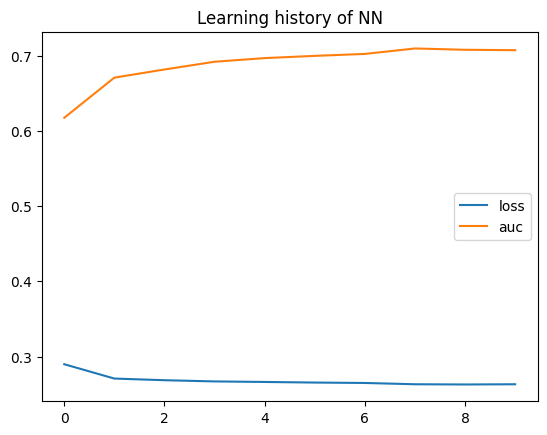

In [51]:
plt.title('Learning history of NN')
plt.plot(TFHistory.history['loss'], label='loss')
plt.plot(TFHistory.history['auc'], label='auc')
plt.legend()
plt.show()

### Моя реализация DNN

In [52]:
class MyDNN():
    def __init__(self, hp):        
        self.epochs = hp.get('epochs', 50)
        self.batch_size = hp.get('batch_size', 512)
        self.alpha = hp.get('alpha', 0.01)
        self.hidden = hp.get('hidden', 32)
        
    def relu(self, t):
        return np.maximum(t, 0)

    def softmax(self, t):
        out = np.exp(t)
        return out / np.sum(out)

    def softmax_batch(self, t):
        out = np.exp(t)
        return out / np.sum(out, axis=1, keepdims=True)

    def sparse_cross_entropy(self, z, y):
        return -np.log(z[0, y])

    def sparse_cross_entropy_batch(self, z, y):
        return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

    def to_full(self, y, num_classes):
        y_full = np.zeros((1, num_classes))
        y_full[0, y] = 1
        return y_full

    def to_full_batch(self, y, num_classes):
        y_full = np.zeros((len(y), num_classes))
        for j, yj in enumerate(y):
            y_full[j, yj] = 1
        return y_full

    def relu_deriv(self, t):
        return (t >= 0).astype(float)
    
    def init_weight(self, layer_sizes):
    
        self.INPUT_DIM = layer_sizes.get('in', 512)
        self.H_DIM = layer_sizes.get('hidden', 32)
        self.OUT_DIM = layer_sizes.get('out', 1)
        
        self.W1 = np.random.rand(self.INPUT_DIM, self.H_DIM)
        self.b1 = np.random.rand(1, self.H_DIM)
        self.W2 = np.random.rand(self.H_DIM, self.OUT_DIM)
        self.b2 = np.random.rand(1, self.OUT_DIM)

        self.W1 = (self.W1 - 0.5) * 2 * np.sqrt(1/self.INPUT_DIM)
        self.b1 = (self.b1 - 0.5) * 2 * np.sqrt(1/self.INPUT_DIM)
        self.W2 = (self.W2 - 0.5) * 2 * np.sqrt(1/self.H_DIM)
        self.b2 = (self.b2 - 0.5) * 2 * np.sqrt(1/self.H_DIM)
    
    def forward(self, X):
        self.t1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.t1)
        self.t2 = self.h1 @ self.W2 + self.b2
        y_predict = self.softmax_batch(self.t2)
        return y_predict
    
    def backward(self, X, y):
        self.y_full = self.to_full_batch(y, self.OUT_DIM)
        
        self.dE_dt2 = self.z - self.y_full
        self.dE_dW2 = self.h1.T @ self.dE_dt2
        self.dE_db2 = np.sum(self.dE_dt2, axis=0, keepdims=True)
        
        self.dE_dh1 = self.dE_dt2 @ self.W2.T
        self.dE_dt1 = self.dE_dh1 * self.relu_deriv(self.t1)
        self.dE_dW1 = X.T @ self.dE_dt1
        self.dE_db1 = np.sum(self.dE_dt1, axis=0, keepdims=True)
        
    def update_weight(self):
        self.W1 = self.W1 - self.alpha * self.dE_dW1
        self.b1 = self.b1 - self.alpha * self.dE_db1
        self.W2 = self.W2 - self.alpha * self.dE_dW2
        self.b2 = self.b2 - self.alpha * self.dE_db2
        
    def fit(self, X, Y):    
        roc_auc_s = []
        layer_sizes = {
            'in': len(X[0]),
            'hidden': self.hidden,
            'out': len(set(Y)),
        }
        self.init_weight(layer_sizes)

        dataset = [(X[i][None, ...], Y[i]) for i in range(len(Y))]
        
        for i_epoch in range(self.epochs):
            for i_batch in range(len(dataset) // self.batch_size):

                start_batch = i_batch * self.batch_size
                finist_batch = start_batch + self.batch_size
                
                batch_x, batch_y = zip(*dataset[start_batch : finist_batch])

                x = np.concatenate(batch_x, axis=0)
                y = np.array(batch_y)              
                self.z = self.forward(x)
                self.backward(x, y)
                self.update_weight()
                            
            y_proba = self.predict(X)[:, 1]
            roc = roc_auc_score(Y, y_proba)
            roc_auc_s.append(roc)
        return roc_auc_s
        
    def predict(self, X):
        return self.forward(X)

In [53]:
class WrapperMyDNN:
    def __init__(self, hp):
        self.model = hp['model']
        
    def fit(self, X, y):
        self.history = self.model.fit(X.values, y.values)
        
    def predict(self, X):
        return self.model.predict(X.values.astype('float32'))[:, 1]

In [54]:
config = {'epochs': 20, 'batch_size': 512, 'hidden': 32}
dnn = MyDNN(config)
config['model'] = dnn
res_table, models = myPredict(res_table, data, WrapperMyDNN, config)
res_table

name: WrapperMyDNN: {"epochs": 20, "batch_size": 512, "hidden": 32}
train AUC: 0.7913016337196642
test AUC: 0.7847368289092558
train ACC: 0.9169740139080492
test ACC: 0.9181564796306202
config: {'epochs': 20, 'batch_size': 512, 'hidden': 32}


,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
1,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
2,"WrapperKeras: {""epochs"": 50}",0.844819,0.833026,0.919223,0.919986,{'epochs': 50}
3,"WrapperKeras: {""epochs"": 200}",0.862372,0.840100,0.920078,0.919803,{'epochs': 200}
4,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."
5,"WrapperRFGridSearch: {""n_estimators"": [200], ""...",0.999994,0.841962,0.997582,0.920395,"{'n_estimators': [200], 'max_features': ['sqrt..."
6,"WrapperMyDNN: {""epochs"": 20, ""batch_size"": 512...",0.791302,0.784737,0.916974,0.918156,"{'epochs': 20, 'batch_size': 512, 'hidden': 32}"


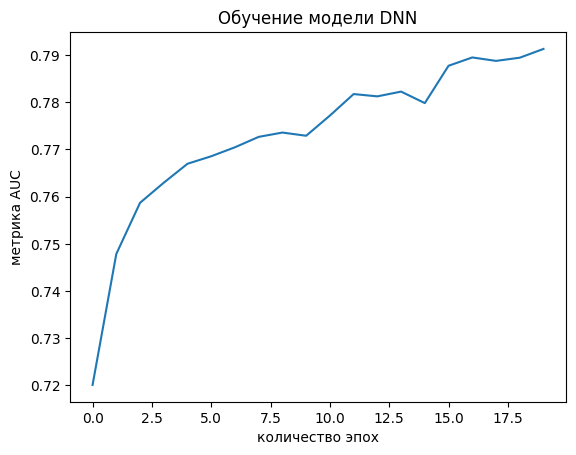

In [56]:
history = models['WrapperMyDNN: {"epochs": 20, "batch_size": 512, "hidden": 32}'].history
plt.title('Обучение модели DNN')
pd.Series(history).plot(xlabel='количество эпох', ylabel='метрика AUC')
plt.show()